In [3]:
import pandas as pd

from music21 import scale, pitch, stream, note, environment
environment.set('musescoreDirectPNGPath', 'D:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe')

from yfinance import download as stock_price_download
from math import isclose, floor

### Create conversion dicts to go between a note and a midi value

In [4]:
notes: list[str] = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
octaves = [i for i in range(-1, 10)]

note_to_midi = {
    note: midi_code for midi_code, note in \
    enumerate([note + str(octave) for octave in octaves for note in notes]) \
    if midi_code < 128
    }

midi_to_note = {v: k for k,v in note_to_midi.items()}


### Generate patterns for major and minor scales

In [14]:
ScaleList = list[scale.Scale]

scale_fns = [
    # Major and Minor scales
    scale.MajorScale, scale.MinorScale, scale.HarmonicMinorScale, scale.MelodicMinorScale
    # scale.WeightedHexatonicBlues, 

    # Pseudo-raga scales, note they may have differences between ascending and descending pitches
    # Pseudo-raga
    # scale.RagAsawari, scale.RagMarwa,

    # Oddballs
    # scale.WholeToneScale
]

scales: ScaleList = [
    f(note) for note in notes for f in scale_fns
]

# add concrete scales for pentatonic and blues scales
blues_minor_indices = [0, 3, 5, 6, 7, 10]
minor_pentatonic_indices = [0, 3, 5, 7, 10]

def first_to_last(l: list):
    l.append(l.pop(0))
    return l



# sc.abstract.getDegreeMaxUnique()
# [str(p) for p in sc2.getPitches('g2', 'g4', direction='descending')]



In [15]:
major_steps = ["W", "W", "H", "W", "W", "W", "H"]
minor_steps = ["W", "H", "W", "W", "H", "W", "W"]
# Note: melodic minor scales lower degrees 6&7 going down
# may be interesting to implement algo to raise and lower notes 
# based on increasing or decreasing runs of notes
melodic_minor_steps = ["W", "H", "W", "W", "W", "W", "H"]
harmonic_minor_steps = ["W", "H", "W", "W", "H", "W+H", "H"]
pentatonic_major_steps = ["W", "W", "W+H", "W", "W+H"]
pentatonic_minor_steps = ["W+H", "W", "W", "W+H", "W"]
japanese_mode_steps = ["H", "W+W", "W", "H", "W+W"]
blues_major_steps = ["W", "W+H", "W", "W", ]
blues_minor_steps = []
egyptian_suspended_steps = ["W", "W+H","W"]

modes: list[str] = ["Ionian", "Dorian", "Phrygian", "Lydian", "Myxolydian", "Aeolian", "Locrian"]

### Read Financial Data

In [16]:
ticker: str = "PTON"
start_date: str = "2020-01-01"
end_date: str = "2022-01-01"

df: pd.DataFrame = stock_price_download(ticker, start_date, end_date)

steps = 32

num_entries: int = len(df)
step_factor: int = floor(num_entries / steps) 

# filtered_df = df.iloc[::step_factor]
filtered_df = df


min_value: float = df.min()
max_value: float = df.max()
value_range: float = max_value - min_value

normalized_df = (filtered_df - min_value) / value_range

normalized_df.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,0.069578,0.062596,0.069055,0.069164,0.069164,0.041218
2020-01-03,0.073579,0.070769,0.079242,0.074978,0.074978,0.030132
2020-01-06,0.081175,0.073792,0.082182,0.069231,0.069231,0.019010
2020-01-07,0.073240,0.068044,0.076097,0.073626,0.073626,0.007751
2020-01-08,0.077513,0.064124,0.076234,0.068555,0.068555,0.059549


### Convert to midi notes and count note occurrences

In [17]:
# Scale fractions to possible midi values

start_note: str = "A2"
end_note: str = "A7"


start_value: int = pitch.Pitch(start_note).midi
end_value: int = pitch.Pitch(end_note).midi

midi_df = start_value + normalized_df * end_value

# Collapse to stream

stock_stream = stream.Stream()
stock_stream.id = f"Note sequence for {ticker}"

#TODO: look into setting up fancier things like adding a clef and time signature, populating bar lines, etc.

midi_df['Open'].agg( lambda x: stock_stream.append(note.Note(pitch.Pitch(midi=x), type='quarter')) )

# NOTE: This command requires musescore (or equiv.) to run
# stock_stream.show()

# Runs Krumhansl Schmuckler Algorithm to determine key
# There are more options to explore here with weighting implementations, not sure how they work 
stock_stream.analyze('key')

<music21.key.Key of B major>

<music21.graph.plot.HistogramPitchClass for <music21.stream.Stream Note sequence for PTON>>

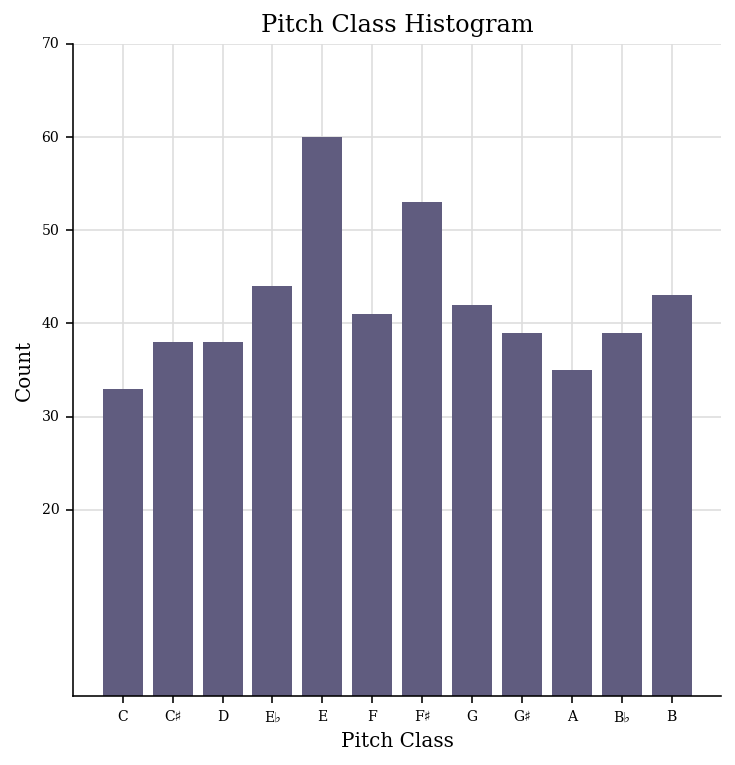

In [18]:
# some graphs from the stream

stock_stream.plot('histogram', 'pitchClass')

<music21.graph.plot.HistogramPitchSpace for <music21.stream.Stream Note sequence for PTON>>

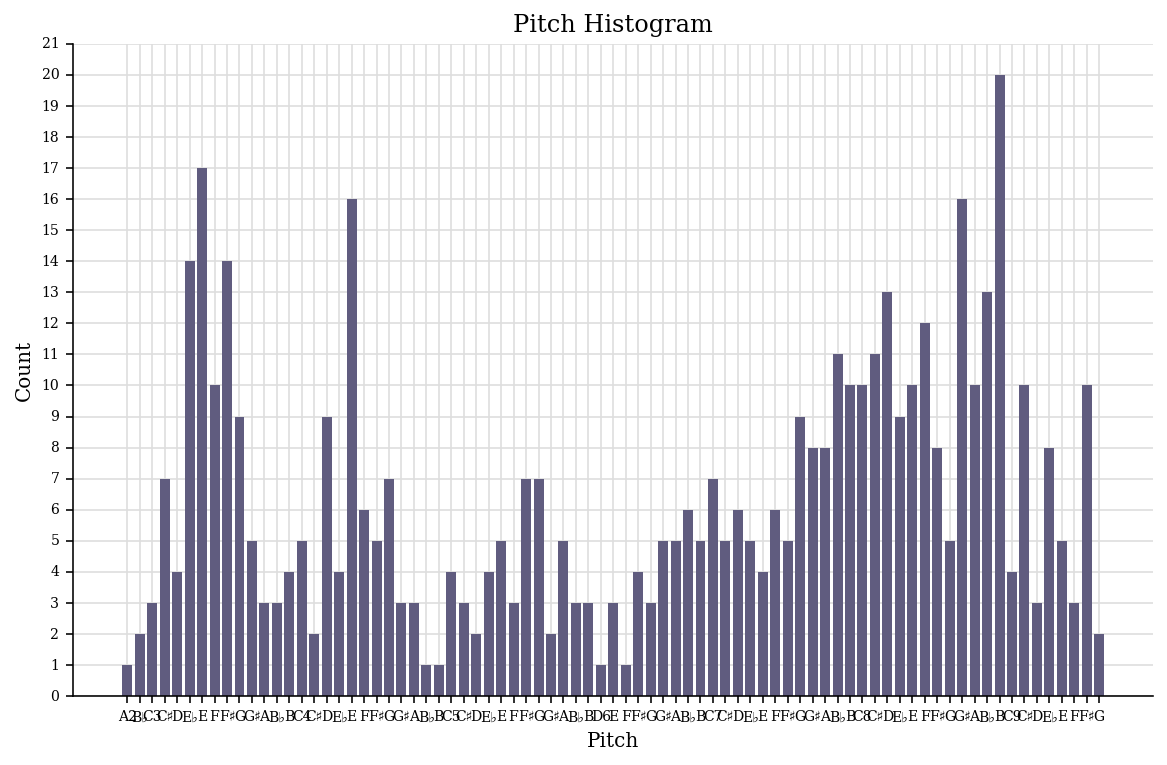

In [19]:
stock_stream.plot('histogram', 'pitchSpace')

In [20]:
# get pitch class and space values in dictionary

# TODO: there's probably an elegant way to do this I don't yet see

note_set = {p.name for p in stock_stream.pitches}

note_counts = {n: len([ p for p in stock_stream.pitches if p.pitchClass == pitch.Pitch(n).pitchClass ]) for n in note_set}
pitch_class_counts = {pitch.Pitch(k).pitchClass: v for k, v in note_counts.items()}

print(f"Stream Length: {len(stock_stream)}")
print(f"Total Counts: {sum(note_counts.values())}")
print(note_counts)


Stream Length: 505
Total Counts: 505
{'A': 35, 'G#': 39, 'D': 38, 'E-': 44, 'F#': 53, 'C': 33, 'G': 42, 'E': 60, 'F': 41, 'B-': 39, 'B': 43, 'C#': 38}


In [21]:
# NOTE: Check enharmonic equality by adding .ps


def maximize_in_scale(notes: stream.Stream, scales: ScaleList):
    closest_scale: list[str] = []
    max_metric = 0

    for sc in scales:

        # TODO: I believe ps only accounts for either ascending or descending values in a scale, should work on adding values from descending scale values
        
        ps = {p.pitchClass for p in sc.pitches}

        # TODO: Should rethink metric to penalize scales with more notes (ex: blues hexatonic and pseudo-ragas)

        metric = sum([pitch_class_counts[p] for p in ps]) / len(ps)

        if metric > max_metric:
            closest_scale = [sc]
            max_metric = metric
        elif isclose(metric, max_metric):
            closest_scale.append(sc)

    return closest_scale 


maximize_in_scale(stock_stream, scales)

[<music21.scale.MinorScale G# minor>, <music21.scale.MajorScale B major>]

In [24]:
# Analyze how well this algorithm performs vs the music21's key analyzer by looping through Nasdaq 500

sp_df = pd.read_csv('sandp500.csv')

sp_df.drop(['Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date first added', 'CIK', 'Founded'], axis=1, inplace=True)



for ticker in sp_df['Symbol']:
    
    # read yfinance data for ticker

    # convert to stream

    # compare maximize_in_scale to .analyze('key') by checking if the latter is in the former


    continue

sp_df.head()


,Symbol
0,MMM
1,AOS
2,ABT
3,ABBV
4,ABMD


In [58]:
# TODO: look at triads of notes, pick out the consonant chords

61.0